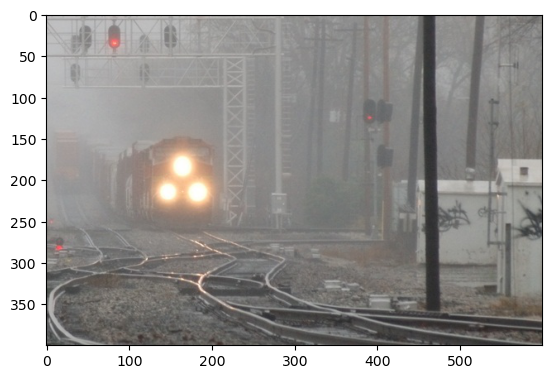

In [147]:
'''
    实验内容：复现何凯明去雾算法
    参考：https://blog.csdn.net/qq_45906101/article/details/127681893
'''
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

# 查看需要去雾的图片
img = cv2.imread('image/work4-3.jpg')
I = img.astype('float32') / 255.0
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [148]:
# 查看图片尺寸
img.shape

(400, 600, 3)

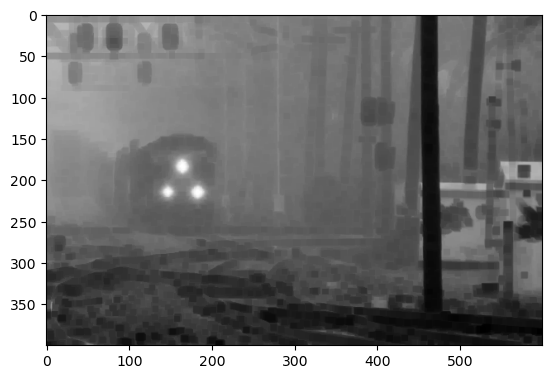

In [149]:
'''
    第一步：求暗通道 dark
'''
# 获取三通道最小值
r, g, b = cv2.split(img)
min_data = cv2.min(cv2.min(r,g),b)
# 卷积核 窗口为15x15，即最小滤波的半径为7
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
# 图像腐蚀
dark = cv2.erode(min_data, kernel)
# 查看图片
plt.imshow(dark,cmap="gray")

# 封装
def darkchannel(img):
    r,g,b = cv2.split(img)
    min_data=cv2.min(cv2.min(r,g),b)
    kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(15,15))
    dark=cv2.erode(min_data,kernel)
    return dark

In [150]:
'''
    第二步：计算大气光 A
'''
[h, w] = img.shape[: 2]
# 像素个数
img_size = h * w  
# 选取前0.1%的像素
numpx = int(max(math.floor(img_size/1000),1)) 
# 按通道向量
darkvec = dark.reshape(1,img_size) 
# 将每个通道都变成(1,img_size)，为了根据索引求和
bvec = b.reshape(1,img_size)
gvec = g.reshape(1,img_size)
rvec = r.reshape(1,img_size)
# 暗通道向量值按照从小到大排，并返回索引
index = darkvec.argsort() 
# 获取到前0.1%的像素在darkvex中的索引值
index = index[:,img_size - numpx::]
A = np.zeros([1,3])
# 下列是分别求取前0.1%的原图像素在各通道的像素值
for j in range(0,numpx):
    A[0,0] += bvec[0,index[0,j]]
for j in range(0,numpx):
    A[0,1] += gvec[0,index[0,j]]
for j in range(0,numpx):
    A[0,2] += rvec[0,index[0,j]]
# 把这些像素的平均值作为大气光
A /= numpx

print(A)

[[253.27083333 254.7625     254.55833333]]


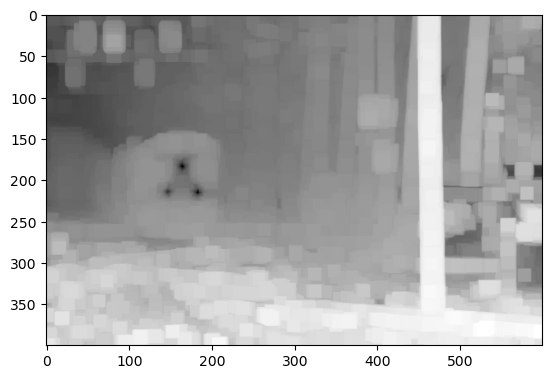

In [151]:
'''
    第三步：计算原始传输率 t
'''
omega = 0.95
ia = np.empty(I.shape, I.dtype)
for i in range(0, 3):
    #每个通道单独计算
    ia[:,:,i] = I[:,:,i] / A[0,i]  
#与论文中公式一致
trans = 1 - omega * darkchannel(ia)
plt.imshow(trans,cmap='gray')

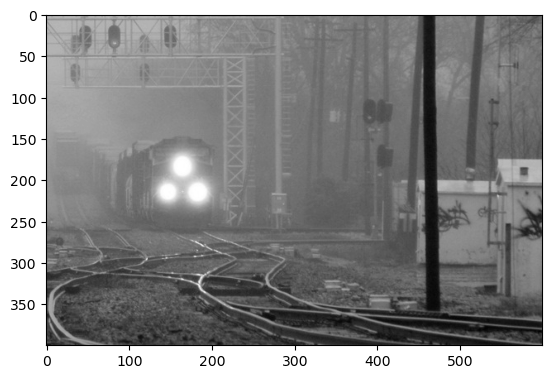

In [152]:
'''
    第四步：导向滤波 可以保留图像边缘的同时 给图像去噪 让图像变光滑
'''
# 图像空间转换 转换成灰度图
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# 0-1
gray = np.float32(gray)/255
plt.imshow(gray,cmap="gray")

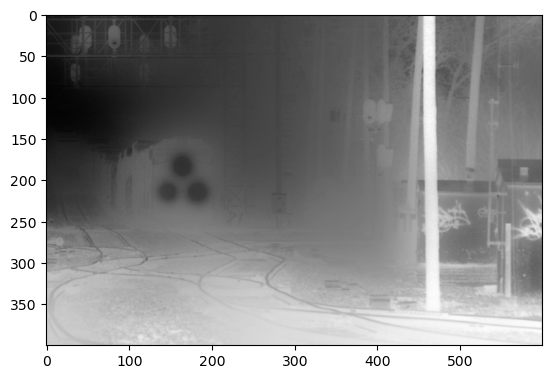

In [153]:
# 滤波半径
r = 60
eps = 0.001
# 导向滤波实际实现
mean_I = cv2.boxFilter(gray, -1, (r, r))
mean_p = cv2.boxFilter(trans, -1, (r, r))
mean_Ip = cv2.boxFilter(gray * trans, -1, (r, r))
cov_Ip = mean_Ip - mean_I * mean_p

mean_II = cv2.boxFilter(gray * gray, -1, (r, r))
var_I = mean_II - mean_I * mean_I

a = cov_Ip / (var_I + eps)
b = mean_p - a * mean_I

mean_a = cv2.boxFilter(a, -1, (r, r))
mean_b = cv2.boxFilter(b, -1, (r, r))

filter_img = mean_a * gray + mean_b

plt.imshow(filter_img,cmap="gray") 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


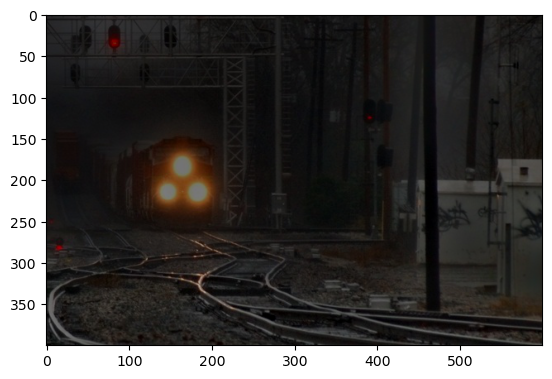

In [165]:
# 恢复原图
res = np.empty(I.shape, I.dtype)
# 有些地方t可能趋近于0，保留大量雾霾去雾的少量雾霾 设置t的一个最小下界为0.1
filter_img = cv2.max(filter_img, 0.1)  

for ind in range(0, 3):
    res[:, :, ind] = (I[:, :, ind] - A[0, ind]) / filter_img + A[0, ind]

# 查看恢复的图
res = cv2.cvtColor(res,cv2.COLOR_BGR2RGB)
plt.imshow(res)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


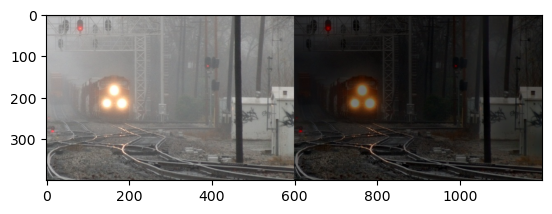

In [166]:
# 查看对比效果
I = cv2.cvtColor(I,cv2.COLOR_BGR2RGB)
com = np.hstack((I, res))
plt.imshow(com)